In [1]:
from sklearn.cluster import DBSCAN
from imutils import build_montages
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
print("[INFO] Loading face encodings...")
data = pickle.loads(open("encodings.pickle", "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]

[INFO] Loading face encodings...


In [3]:
n_components_values = list(range(1, min(len(encodings[0]), len(encodings)) + 1))

explained_variances = []

for n_component in n_components_values:
    pca = PCA(n_components=n_component)
    pca.fit(encodings)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

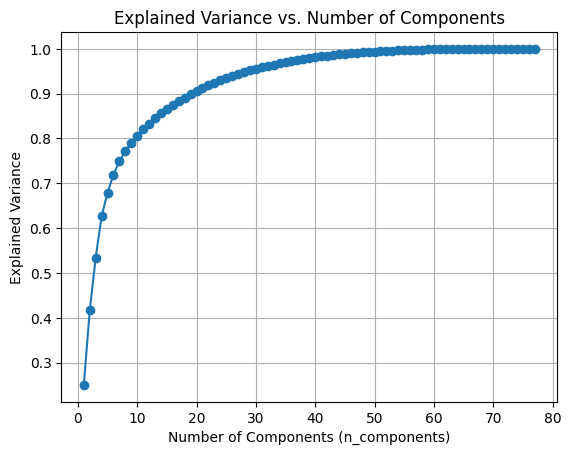

In [4]:
plt.plot(n_components_values, explained_variances, marker='o')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [5]:
for i, ev in enumerate(explained_variances):
    if (0.8 < ev < 0.9):
        print(i, ":", "%.2f" % ev, end=", ")

9 : 0.81, 10 : 0.82, 11 : 0.83, 12 : 0.84, 13 : 0.86, 14 : 0.87, 15 : 0.87, 16 : 0.88, 17 : 0.89, 18 : 0.90, 

In [6]:
pca = PCA(n_components=12)
reduced_data = pca.fit_transform(encodings)

In [7]:
# cluster the embeddings
print("[INFO] Clustering using DBSCAN...")
clt = DBSCAN(eps=0.36, min_samples=6, metric="euclidean", n_jobs=-1)
clt.fit(reduced_data)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
# print(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] Number of unique faces: {}".format(numUniqueFaces))

[INFO] Clustering using DBSCAN...
[INFO] Number of unique faces: 6


In [10]:
# import the necessary packages
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import gc
import sys

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--dataset", default="dataset",
    help="path to input directory of faces + images")
ap.add_argument("-e", "--encodings", default="encodings.pickle",
    help="path to serialized db of facial encodings")
ap.add_argument("-d", "--detection-method", type=str, default="cnn",
    help="face detection model to use: either `hog` or `cnn`")

# FIX: Jupyter/IPython safe parsing
args = vars(ap.parse_args(args=[] if sys.argv[0].endswith("ipykernel_launcher.py") else None))

# grab the paths to the input images in our dataset
imagePaths = list(paths.list_images(args["dataset"]))
data = []

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    print("[INFO] Processing image {}/{}".format(i + 1, len(imagePaths)))
    print(imagePath)

    # load the input image and convert it from BGR to RGB
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # resize image if too large to reduce memory load
    if rgb.shape[1] > 750:
        scale = 750 / rgb.shape[1]
        rgb = cv2.resize(rgb, (750, int(rgb.shape[0] * scale)))

    # detect face locations
    boxes = face_recognition.face_locations(rgb, model=args["detection_method"])

    # compute the facial embeddings
    encodings = face_recognition.face_encodings(rgb, boxes)

    # build a dictionary and add it to the list
    d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
         for (box, enc) in zip(boxes, encodings)]
    data.extend(d)

    # free memory
    del image, rgb, boxes, encodings, d
    gc.collect()

# write the encodings to disk
print("[INFO] Serializing encodings...")
with open(args["encodings"], "wb") as f:
    f.write(pickle.dumps(data))


[INFO] Processing image 1/62
dataset\01.jpg
[INFO] Processing image 2/62
dataset\02.jpg
[INFO] Processing image 3/62
dataset\03.JPG
[INFO] Processing image 4/62
dataset\04.jpg
[INFO] Processing image 5/62
dataset\05.JPG
[INFO] Processing image 6/62
dataset\06.JPG
[INFO] Processing image 7/62
dataset\07.jpg
[INFO] Processing image 8/62
dataset\08.JPG
[INFO] Processing image 9/62
dataset\09.JPG
[INFO] Processing image 10/62
dataset\10.jpg
[INFO] Processing image 11/62
dataset\11.jpg
[INFO] Processing image 12/62
dataset\12.jpg
[INFO] Processing image 13/62
dataset\13.jpg
[INFO] Processing image 14/62
dataset\14.jpg
[INFO] Processing image 15/62
dataset\15.jpg
[INFO] Processing image 16/62
dataset\16.jpg
[INFO] Processing image 17/62
dataset\17.jpg
[INFO] Processing image 18/62
dataset\18.jpg
[INFO] Processing image 19/62
dataset\19.jpg
[INFO] Processing image 20/62
dataset\20.jpg
[INFO] Processing image 21/62
dataset\21.jpg
[INFO] Processing image 22/62
dataset\22.jpg
[INFO] Processing i

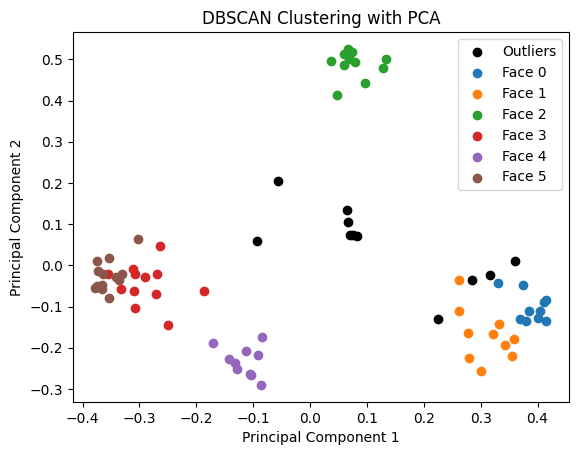

In [11]:
for label in labelIDs:
    if label == -1:
        plt.scatter(reduced_data[clt.labels_ == label, 0], reduced_data[clt.labels_ == label, 1], color='black', label='Outliers')
    else:
        plt.scatter(reduced_data[clt.labels_ == label, 0], reduced_data[clt.labels_ == label, 1], label=f'Face {label}')

plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering with PCA')
plt.show()
